In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import requests
sys.path.append(os.path.abspath('../src'))

import matplotlib
import matplotlib.pyplot as plt

# --- CRITICAL: Force interactive backend ---
%matplotlib inline
import matplotlib
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['toolbar'] = 'toolmanager'
# OR for scripts:
# matplotlib.use('TkAgg')   # or 'Qt5Agg'
import matplotlib.pyplot as plt

from load_data import load_raw
from preprocess import clean_data, select_column, rename, sales_and_residential, drop_na, add_cities, make_zero, geocode, geo_address, one_hot
from train_model import train_random_forest
from evaluate import evaluate_model, compute_shap_local, compute_shap_global, feature_i, shap_initialise, compute_shap_cluster


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\ktlee\AppData\Local\Temp\ipykernel_40244\1314568982.py:16: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  matplotlib.rcParams['toolbar'] = 'toolmanager'


Step 1: Load data and delete the data that is not our target cities

In [ ]:
import pandas as pd

path = r"C:\Users\ktlee\Downloads\all_transactions.csv"
df_raw = load_raw(path)

In [ ]:
df_renamed = rename(df_raw)
df_selected = select_column(df_renamed)
df_filtered = sales_and_residential(df_selected)
df_dropped = drop_na(df_filtered)
df_with_city = add_cities(df_dropped)
df_with_zero = make_zero(df_with_city)



In [ ]:
#Externally download the street data
df_with_zero['Full addr'] = (
        df_with_zero['Street number'].astype(str).str.strip() + ' ' +
        df_with_zero['Street name'].astype(str).str.strip() + ', ' +
        df_with_zero['Postal code'].astype(str).str.strip() + ' ' +
        df_with_zero['Municipality'].astype(str).str.strip()
    )
df = df_with_zero.copy()
df.drop(columns=['Street number', 'Street name', 'Postal code', 'Municipality'], inplace=True)
#df.to_csv(r"C:\Users\ktlee\Downloads\clean_data_new.csv", index = False)

In [ ]:
#Add back the longtitude and latitude
df_address = pd.read_csv(r"C:\Users\ktlee\Downloads\clean_address_dict.csv")
df_address.columns = ['Full addr', 'Longitude', 'Latitude']
#df_address.head
#df_with_zero.columns
df_geocoded = df_with_zero.merge(df_address, on = 'Full addr', how = 'left')

df_clean_geo = df_geocoded[
    (df_geocoded['Longitude'].notna() & df_geocoded['Latitude'].notna()) &
    (df_geocoded['Longitude'] != 0) & (df_geocoded['Latitude'] != 0)
]


In [ ]:
#One-hot coding
df_all_eng = one_hot(df_clean_geo)
df_all_eng.dtypes

df_all_eng.to_csv(r"C:\Users\ktlee\Downloads\df_all_eng.csv")



Step 2: For each city, pre-process and train

In [3]:
import numpy as np
import pandas as pd

df_all_eng = pd.read_csv('../data/df_all_eng.csv')
df_all_eng['City'] = np.where(df_all_eng['City'] == 'Montepliier', 'Montepiller', df_all_eng['City'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model training finished

                    MODEL EVALUATION
Q1                  : 7,555.0000000000
MedAE               : 18,952.0320000000
Q3                  : 36,041.8240000000
MAE                 : 26,452.0961707236
RMSE                : 37,325.9428472640
R2                  : 0.2846699964
MAPE (%)            :    67.24
MedAE (€)           : 18,952.0320000000
MSLE                : 0.2127828677
Start initialising


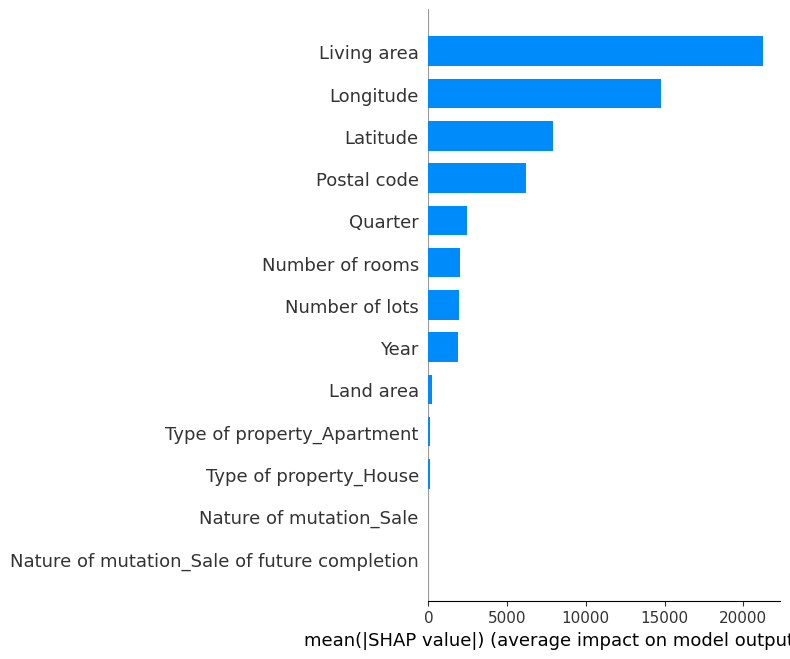

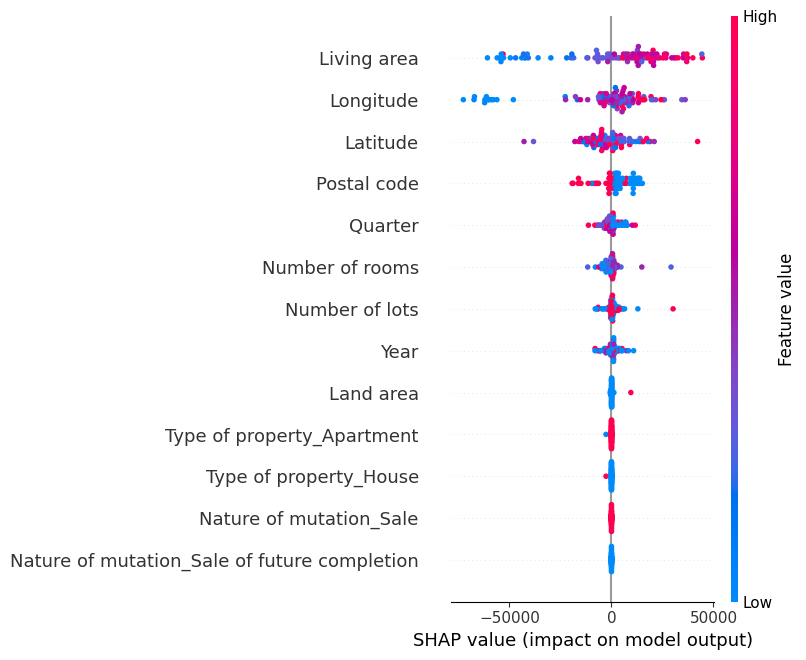

<class 'shap.explainers._tree.TreeExplainer'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
City Montepiller's model training is done.


In [ ]:
df = df_all_eng
cities = df['City'].unique()

#print(cities)

# For now, use sample for testing
#df_sample = df.head(1000).copy()  # Remove later
#df_sample = geocode(df_sample)   # Test geocoding

metrics_table = dict()
feature_table = dict()
shap_values_table = dict()
X_sample_table = dict()

training_city = ['Montepiller']

for city in cities:
    if city not in training_city:
        continue
    df_city = df[df['City'] == city].copy()
    #print(df_city['Property value'])
    X, y = clean_data(df_city)

    case_model = 1 #<-- Change this

    #Case 3: Only print output, without machine learning
    if case_model == 3:
        print(f"{city}: {df_city.describe()}")

    #Case 1: Let the program to find best model
    if case_model == 1:
        model, params, X_test, y_test, best_params = train_random_forest(X, y)

    #Case 2: Self define the model
    if case_model == 2:
        param_grid = {
                'n_estimators': [2500],
                'max_depth': [32],
                'bootstrap': [False]
            }
        model, params, X_test, y_test = train_random_forest(X, y, param_grid)
        print("Model training finished")
        best_params = None

    # Evaluate
    if case_model in [1,2]:
        if best_params is not None:
            print(best_params)
        metrics = evaluate_model(model, X_test, y_test)
        metrics_table[city] = metrics
        feature_importance = feature_i(model, X_test)
        print(feature_importance)
        feature_table[city] = feature_importance
        #model_table[city] = model


        explain, shap_values, X_sample = shap_initialise(model, X_test, 100)

        #compute_shap_local(model, X_test, n = 100)
        compute_shap_global(explain, shap_values, X_sample)
        #compute_shap_cluster(explain, shap_values, X_sample)
        shap_values_table[city] = shap_values
        X_sample_table[city] = X_sample

        print(type(explain))
        print(type(shap_values))
        print(type(X_sample))
        
        print(f"City {city}'s model training is done.")

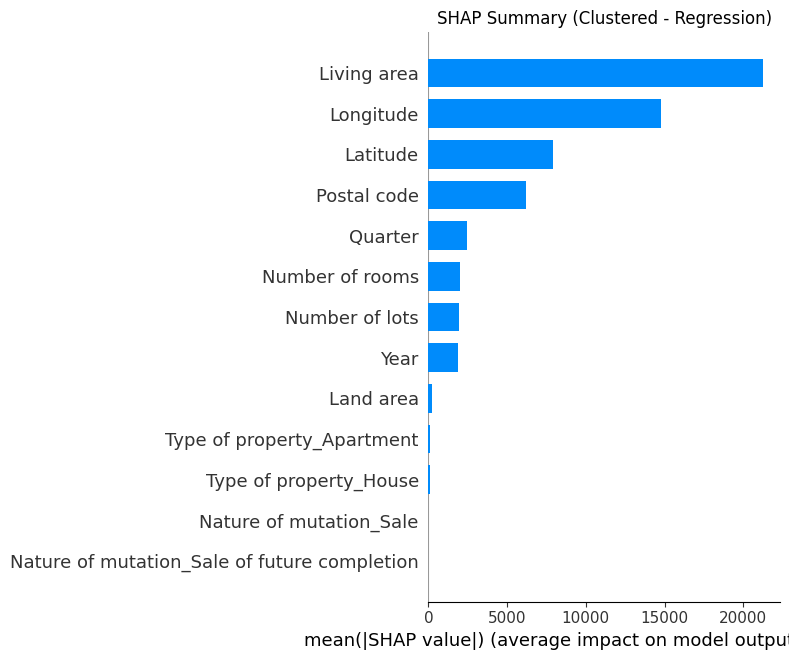

In [14]:
compute_shap_cluster(shap_values, X_sample)

Step 3: Add back the data to t

In [17]:
import os
import pandas as pd

def update_merged_summary(city, metrics, feature_importance, base_path="../reports"):
    # Prepare row for this city
    row = {'City': city}
    row.update(metrics)

    for feature_name, importance in feature_importance.items():
        row[f'Feature: {feature_name}'] = importance

    new_row_df = pd.DataFrame([row]).set_index('City')

    # Path to the summary file
    summary_path = os.path.join(base_path, "merged_summary.csv")

    # Load existing or create new
    if os.path.exists(summary_path):
        merged_df = pd.read_csv(summary_path, index_col='City')
        merged_df = pd.concat([merged_df, new_row_df])
    else:
        merged_df = new_row_df

    # Save updated summary
    merged_df.to_csv(summary_path)
    print(f"Updated summary saved to {summary_path}")

for city in metrics_table:
    update_merged_summary(
        city=city,
        metrics=metrics_table[city],
        feature_importance=feature_table[city]
    )


Updated summary saved to ../reports\merged_summary.csv


In [ ]:
import os
import json

base_dir = '../reports/result'

json.dump(metrics_table)

In [ ]:
explain, shap_values, X_sample = shap_initialise(model, X_test, 100)

print("shap_values type :", type(shap_values))
print("shap_values shape:", shap_values.shape if hasattr(shap_values, 'shape') else [a.shape for a in shap_values])

if True:
    #compute_shap_local(model, X_test, n = 100)
    compute_shap_global(explain, shap_values, X_sample)
    compute_shap_cluster(explain, shap_values, X_sample)